In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from IPython.display import display, clear_output

# import pyro
# import pyro.infer
# import pyro.optim
# import pyro.distributions as dist
import torch.distributions.constraints as constraints
# import pyro.poutine as poutine

from datasets import load_dataset

# pyro.set_rng_seed(1)
# pyro.clear_param_store()

In [5]:
pip install datasets

  Using cached pyarrow-21.0.0-cp312-cp312-macosx_12_0_x86_64.whl.metadata (3.3 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached multiprocess-0.70.16-py312-none-any.whl.metadata (7.2 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 7.2 MB/s eta 0:00:00
Using cached multiprocess-0.70.16-py312-none-any.whl (146 kB)
Using cached pyarrow-21.0.0-cp312-cp312-macosx_12_0_x86_64.whl (32.7 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 10.0 MB/s eta 0:00:00a 0:00:01
Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
Using cached aiosignal-1.4.0-py3-none-any.whl (7.5 kB)
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.2
    Uninstalling tqdm-4.66.2:
      Successfully uninstalled tqdm-4.66.2
  Attempting uninstall: reques

In [78]:
from datasets import logging
logging.set_verbosity_error()


ds = load_dataset("armanc/pubmed-rct20k")

Repo card metadata block was not found. Setting CardData to empty.


In [79]:
print(ds)

# one row 
print(ds["train"][0])

DatasetDict({
    train: Dataset({
        features: ['abstract_id', 'label', 'text', 'sentence_id'],
        num_rows: 176642
    })
    validation: Dataset({
        features: ['abstract_id', 'label', 'text', 'sentence_id'],
        num_rows: 29672
    })
    test: Dataset({
        features: ['abstract_id', 'label', 'text', 'sentence_id'],
        num_rows: 29578
    })
})
{'abstract_id': '24293578', 'label': 'objective', 'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .', 'sentence_id': 0}


In [80]:
ds.keys()

dict_keys(['train', 'validation', 'test'])

In [81]:
train_df = ds["train"].to_pandas()

# recombine sentences into full abstracts
abstracts = (train_df.sort_values(["abstract_id", "sentence_id"])
    .groupby("abstract_id")["text"]
    .apply(lambda s: " ".join(s))
    .reset_index()
)

print(abstracts.head())
print(f"\nReconstructed {len(abstracts)} abstracts from {len(train_df)} sentences")

  abstract_id                                               text
0    24219770  The purpose of this study was to determine the...
1    24219814  Repeated courses of intravenous ( IV ) aminogl...
2    24219842  To determine whether the Pediatric Asthma Cont...
3    24219852  Despite the benefits of endoscopic nasobiliary...
4    24219882  We assessed the impact of hot flashes and vari...

Reconstructed 15000 abstracts from 176642 sentences


In [82]:
# Sample abstracts 300 abstracts after recombining    #3000
sampled_abs = abstracts.sample(n=300, random_state=42).reset_index(drop=True)

# id's ofselected abstracts
sel_ids = sampled_abs["abstract_id"].astype(str)


#  optional - subset the original sentence-level split for later use
train_df_small = train_df[train_df["abstract_id"].astype(str).isin(sel_ids)]

abstracts = sampled_abs

print(abstracts.head())
print(f" {len(abstracts)} ")

  abstract_id                                               text
0    25416486  Patient centred and individually-tailored coun...
1    24845394  The steady-state pharmacokinetics of two doses...
2    25651741  NT-pro-BNP level is increased in both systolic...
3    24300949  This study aims to determine the long-term eff...
4    24794277  The aim of this trial was to compare the rates...
 300 


In [83]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

def preprocess(text):
    # to lower case
    text = text.lower()      
    # remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", " ", text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords & short words
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nedamohseni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [84]:
tokenized = [preprocess(abs) for abs in abstracts["text"]]

In [108]:
from collections import Counter

all_words = [w for doc in tokenized for w in doc]
counts = Counter(all_words)

# Define stoplist
stop = { "intervention", "patients","patient","group","groups","treatment","treated","study","studies",
    "randomized","randomised","trial","control","controlled","placebo","compared","comparison",
    "significant","significantly","outcome","outcomes","baseline","participants",
    "month","months","week","weeks","year","years","day","days","time",
    "difference","differences","received","dose","effect","effects","primary","follow","follow-up",
    "random","randomly","versus","respectively","data","used","using","analysis","results",
    "evaluate","assessed","quality","safety","events","reduction", "lsb","rsb", "one", "two", 
    "total", "number", "mean", "median", "range" , "increased", "associated", "women", 
    "based","changes","change","levels","daily","score","response","use","arm",
    "usual","care","health","life","lower"} 


print(stop)
# Filter out stop words from vocabulary
filtered_counts = {word: count for word, count in counts.items() if word not in stop}

vocab_size = 200   # was 20000
vocab_list = [w for w, _ in sorted(filtered_counts.items(), key=lambda x: x[1], reverse=True)[:vocab_size]]
vocab = {w: i for i, w in enumerate(vocab_list)}
i2word = {i: w for w, i in vocab.items()}

print(f"Vocabulary size: {len(vocab)}")
print(f"Removed {len(stop)} stop words from vocabulary")

{'weeks', 'usual', 'participants', 'effect', 'data', 'difference', 'randomly', 'assessed', 'rsb', 'life', 'lsb', 'total', 'associated', 'change', 'randomized', 'controlled', 'intervention', 'random', 'results', 'day', 'care', 'treated', 'week', 'range', 'comparison', 'median', 'patients', 'levels', 'study', 'patient', 'month', 'effects', 'two', 'years', 'trial', 'based', 'baseline', 'dose', 'used', 'reduction', 'use', 'changes', 'significantly', 'compared', 'outcome', 'safety', 'placebo', 'months', 'score', 'daily', 'arm', 'differences', 'time', 'studies', 'events', 'number', 'treatment', 'received', 'outcomes', 'follow', 'control', 'group', 'versus', 'days', 'mean', 'quality', 'respectively', 'lower', 'women', 'significant', 'randomised', 'response', 'primary', 'year', 'evaluate', 'increased', 'follow-up', 'analysis', 'groups', 'using', 'one', 'health'}
Vocabulary size: 200
Removed 57 stop words from vocabulary


In [109]:
tokenized = [[w for w in doc if w not in stop] for doc in tokenized]

In [110]:
# Show the filtered vocabulary (top 20 words)
print("Top 20 words after stoplist filtering:")
for i, word in enumerate(vocab_list[:20]):
    print(f"{i+1:2d}. {word}")


Top 20 words after stoplist filtering:
 1. care
 2. clinical
 3. levels
 4. risk
 5. use
 6. health
 7. therapy
 8. pain
 9. higher
10. response
11. based
12. disease
13. rate
14. daily
15. age
16. efficacy
17. high
18. life
19. score
20. serum


In [111]:
words = []
docs = []

for doc_id, doc in enumerate(tokenized):
    for w in doc:
        if w in vocab:
            words.append(vocab[w])
            docs.append(doc_id)

import numpy as np
words = np.array(words, dtype=int)
docs = np.array(docs, dtype=int)

D = max(docs) + 1
W = max(words) + 1
N = len(docs)

print(f"#docs={D}, vocab size={W}, total tokens={N}")

#docs=300, vocab size=200, total tokens=9628


In [112]:
X = np.zeros((D, W), dtype=int)
for di, wi in zip(docs, words):
    X[di, wi] += 1

In [113]:
# Top-K most frequent words across the whole corpus
K = 100
tf = X.sum(axis=0)                 # term frequencies, shape (W,)
order = np.argsort(-tf)            # descending
top = [(i2word[i], int(tf[i])) for i in order[:K]]
for w, c in top:
    print(f"{w}\t{c}")

clinical	127
risk	124
therapy	113
pain	111
higher	103
disease	97
efficacy	95
age	95
rate	95
high	93
may	87
serum	87
among	82
per	81
assigned	80
exercise	79
ratio	79
increase	79
effective	77
blood	77
children	76
adverse	75
similar	74
either	74
first	72
low	72
double	71
greater	70
observed	69
post	69
scores	69
weight	67
survival	67
non	66
without	65
test	65
standard	65
end	64
smoking	64
rates	64
improved	64
period	64
conducted	63
function	63
surgery	63
measured	63
three	63
also	62
subjects	62
loss	62
pressure	61
related	61
symptoms	60
receive	60
included	60
activity	60
performed	59
secondary	59
blind	59
well	58
reduced	57
concentrations	56
plus	56
whether	56
however	56
improvement	56
reported	55
phase	55
showed	55
effectiveness	55
oral	54
cancer	54
physical	53
level	53
incidence	52
hiv	52
found	52
compare	50
enrolled	50
following	50
statistically	50
chronic	49
healthy	49
self	49
scale	49
assess	49
min	48
early	48
diabetes	47
improve	47
hospital	47
interval	47
adjusted	47
training	47
diff

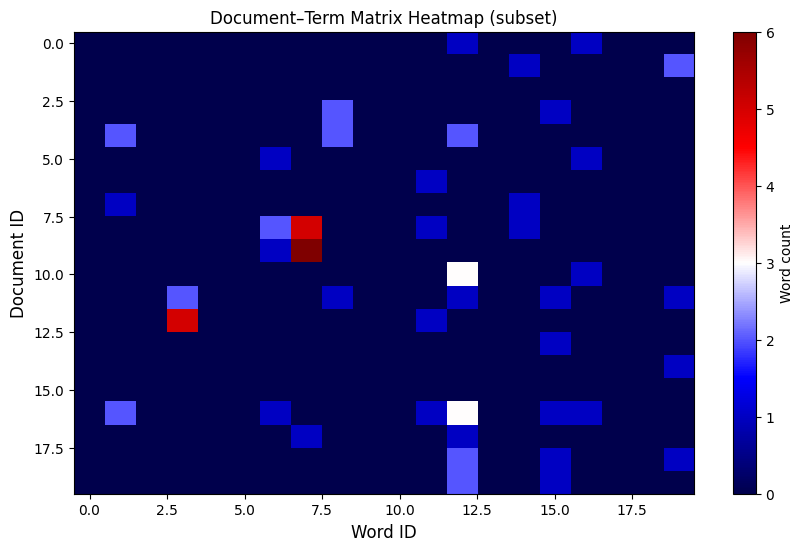

In [114]:
plt.figure(figsize=(10,6))
plt.xlabel("Word ID", fontsize=12)
plt.ylabel("Document ID", fontsize=12)

# For big vocab, plotting everything is overwhelming.
# So let's just look at the first 20 docs × first 20 words:
plt.imshow(X[:20, :20], aspect="auto", cmap="seismic")
plt.colorbar(label="Word count")
plt.title("Document–Term Matrix Heatmap (subset)")
plt.show()

In [115]:
# Initialize our latent assignments Z and set up per-X-topic arrays to keep track of assignment totals

np.random.seed(0)

T = 5        # Only two topics ("HCI" and "Graph theory")
beta = .01     # LDA parameters: control sparsity of documents & topics
alpha = .001

a = np.zeros((D,T),dtype=int)   # total times a token in document d has been assigned to topic t
b = np.zeros((W,T),dtype=int)   # total times word w has been assigned to topic t
c = np.zeros((T,),dtype=int)    # total assignments to topic t

z = np.random.randint(T,size=N);  # assign every token to a topic at random
for n in range(N):
    a[docs[n],z[n]] += 1             # and each document ID
    b[words[n],z[n]] += 1             # count up number for each word ID
    c[z[n]] += 1

In [116]:
def gibbs_collapsed(maxIter):
    for it in range(maxIter):             # for each iteration 
        print(it)
        for i in range(N):                # run through all the words & sample z[i]:
            t = z[i];
            a[docs[i],t] -= 1                # remove token i's assignment from our count vectors
            b[words[i],t] -= 1            
            c[t]      -= 1

            # Compute topic probability distribution given current counts
            probs = (beta + b[words[i],:])/(c[:] + beta*W) * (alpha + a[docs[i],:])

            # Now, normalize and draw a sample from the distribution over topics:
            cumprobs = np.cumsum(probs); cumprobs /= cumprobs[-1] 
            t = np.where(cumprobs>np.random.rand())[0][0]

            z[i] = t;                      # now add this assignment back into our count vectors
            a[docs[i],t] += 1
            b[words[i],t] += 1
            c[t]      += 1

In [117]:
# Helper function for visualizing the learning process
def print_topics():
    '''Print the top 8 words in each topic given the current assignments'''
    for t in range(T):
        isort = np.argsort(-b[:,t])  # find the most likely words for topic t
        xsort = b[isort,t]           # then print topic, % tokens explained, & top 8 words
        print('[{}] ({:.3f}) {}'.format(t, 1.*c[t]/N, list(i2word[isort[ww]] for ww in range(8) if xsort[ww]>0)))

In [118]:
print_topics();       # before running any iterations: random assignment

[0] (0.199) ['clinical', 'similar', 'therapy', 'measured', 'risk', 'pain', 'among', 'assigned']
[1] (0.208) ['high', 'risk', 'children', 'disease', 'pain', 'age', 'higher', 'ratio']
[2] (0.194) ['clinical', 'risk', 'therapy', 'exercise', 'higher', 'blood', 'pain', 'age']
[3] (0.202) ['clinical', 'risk', 'therapy', 'higher', 'observed', 'increase', 'serum', 'efficacy']
[4] (0.196) ['clinical', 'pain', 'rate', 'per', 'therapy', 'weight', 'risk', 'higher']


In [119]:
gibbs_collapsed(400)            # run a bunch of iterations
print_topics();

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [107]:
gibbs_collapsed(800)            # run a bunch of iterations
print_topics();

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27